# Enrichment Analyses
# Phase 1 vs. Phase 1

using [clusterProfiler](https://github.com/YuLab-SMU/clusterProfiler) R package

**Two analyses**
1. [Gene Set Enrichment Analysis](#Gene-Set-Enrichment-Analysis-(GSEA))
2. [Over-Representation Analysis](#Over-Representation-Analysis)

# Gene Set Enrichment Analysis (GSEA)

uses an entire ranked list (by log2FoldChange) of genes to see if pathway genes cluster at the top or bottom

#### Are *pathways* generally over- or under-expressed in a given treatment?

## 0. load libraries

In [2]:
library(tidyverse)
library(clusterProfiler) # for GSEA()
library(enrichplot) # for enrichment visuals
library(GO.db) # for gene ontology database
library(UpSetR) # for Cvirginica annotations
library(patchwork) # for arranging multiple plots

## 1. read in CSVs

read in GO annotation data

In [3]:
# col1 = gene ID
# col2 = GO ID 
gene2go <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
head(gene2go)

,gene,Gene.Ontology.IDs
,<chr>,<chr>
1,LOC111126949,GO:0005042; GO:0005737; GO:0008233; GO:0016020; GO:0043123; GO:0046330
2,LOC111112434,GO:0000981; GO:0003700; GO:0005634; GO:0016607; GO:0043565; GO:0045944
3,LOC111120752,GO:0004750; GO:0005829; GO:0005975; GO:0006098; GO:0009052; GO:0042802; GO:0042803; GO:0046872; GO:0070062
4,LOC111105685,GO:0003682; GO:0004518; GO:0005634; GO:0035098; GO:0035102; GO:0040029; GO:0046872
5,LOC111113860,GO:0004062; GO:0005737; GO:0006068; GO:0006805; GO:0008146; GO:0009812; GO:0030855; GO:0042403; GO:0050427; GO:0051923
6,LOC111109550,GO:0004062; GO:0005737; GO:0005764; GO:0008146; GO:0051923


re-format for correct input for `GSEA()` - two columns, one for GO term and one for gene ID

In [4]:
term2gene <- gene2go %>%
  mutate(GO_terms = strsplit(Gene.Ontology.IDs, ",\\s*|;\\s*|`")) %>%  # Split by comma, semicolon, or backtick
  unnest(GO_terms) %>%
  filter(grepl("^GO:", GO_terms)) %>%  # Keep only valid GO terms
  dplyr::select(term = GO_terms, gene = gene)

class(term2gene)
str(term2gene)
head(term2gene)

[1] "tbl_df"     "tbl"        "data.frame"

tibble [223,103 × 2] (S3: tbl_df/tbl/data.frame)
 $ term: chr [1:223103] "GO:0005042" "GO:0005737" "GO:0008233" "GO:0016020" ...
 $ gene: chr [1:223103] "LOC111126949" "LOC111126949" "LOC111126949" "LOC111126949" ...


term,gene
<chr>,<chr>
GO:0005042,LOC111126949
GO:0005737,LOC111126949
GO:0008233,LOC111126949
GO:0016020,LOC111126949
GO:0043123,LOC111126949
GO:0046330,LOC111126949


get term names for GO IDs

In [5]:
# Extract GO term descriptions
go_terms <- unique(term2gene$term)

# Get descriptions from GO.db
term2name <- data.frame(
  term = go_terms,
  name = sapply(go_terms, function(x) {
    tryCatch({
      Term(GOTERM[[x]])
    }, error = function(e) {
      NA_character_
    })
  })
)

# Remove NAs
term2name <- term2name[!is.na(term2name$name), ]

# View
head(term2name)    

,term,name
,<chr>,<chr>
GO:0005042,GO:0005042,netrin receptor activity
GO:0005737,GO:0005737,cytoplasm
GO:0008233,GO:0008233,peptidase activity
GO:0016020,GO:0016020,membrane
GO:0043123,GO:0043123,positive regulation of canonical NF-kappaB signal transduction
GO:0046330,GO:0046330,positive regulation of JNK cascade


read in *all* genes from DESeq output (not just DEGs)

In [7]:
##### comparisons vs. control
# warm vs. control
w.c <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/all_genes/p1.warm_v_cont.csv')

# both vs. control
b.c <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/all_genes/p1.both_v_cont.csv')

# hyp vs. control
h.c <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/all_genes/p1.hyp_v_cont.csv')

##### other comparisons
# hyp vs. both
h.b <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/all_genes/p1.hyp_v_both.csv')

# warm vs. both
w.b <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/all_genes/p1.warm_v_both.csv')

# warm vs. hyp
w.h <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/all_genes/p1.hyp_v_warm.csv')

## 2. Formatting CSVs
input to `gsea()` is an order ranked geneList - I'm going to rank by log2FoldChange

In [8]:
# data needs to be a numeric vector
# create function for above cell block so can easily apply to other data
format_geneList <- function(df) {
    geneList <- df$log2FoldChange 
    # Set gene IDs as names
    names(geneList) <- df$X
    
    # Sort in decreasing order
    geneList <- sort(geneList, decreasing = TRUE)

    return(geneList)
    }

In [9]:
w.c_geneList <- format_geneList(w.c)
h.c_geneList <- format_geneList(h.c)
b.c_geneList <- format_geneList(b.c)
h.b_geneList <- format_geneList(h.b)
w.b_geneList <- format_geneList(w.b)
w.h_geneList <- format_geneList(w.h)

# check that it worked
class(w.c_geneList)
head(w.c_geneList)

[1] "numeric"

LOC111115187 LOC111137749 LOC111105825 LOC111117559 LOC111105743 LOC111104227 
    25.37117     23.58947     23.40483     22.48910     22.41761     22.15524

## 3. Run GSEA

In [10]:
# warm vs control
gsea_res_w.c <- GSEA(
    geneList = w.c_geneList,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_w.c)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.24% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [11]:
# both vs control
gsea_res_b.c <- GSEA(
    geneList = b.c_geneList,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    verbose = TRUE)
as.data.frame(gsea_res_b.c)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.34% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0050770,GO:0050770,regulation of axonogenesis,19,-0.9982205,-1.508643,1.018614e-05,0.03726088,0.03726088,22,"tags=16%, list=0%, signal=16%",LOC111130881/LOC111125415/LOC111125416


axonogenesis - process in which new axons are formed

In [12]:
# hypoxic vs control
gsea_res_h.c <- GSEA(
    geneList = h.c_geneList,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    verbose = TRUE)
as.data.frame(gsea_res_h.c)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.26% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [13]:
# hypoxic vs both
gsea_res_h.b <- GSEA(
    geneList = h.b_geneList,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    verbose = TRUE)
as.data.frame(gsea_res_h.b)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.77% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
GO:0007274,GO:0007274,neuromuscular synaptic transmission,29,0.9989389,1.413256,9.658798e-06,0.03533188,0.03533188,10,"tags=3%, list=0%, signal=3%",LOC111120179


neuromuscular synaptic transmission - neuron signals to a muscle fiber to contract (?)

In [14]:
# warm vs both
gsea_res_w.b <- GSEA(
    geneList = w.b_geneList,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    verbose = TRUE)
as.data.frame(gsea_res_w.b)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.72% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [15]:
# warm vs hypoxic
gsea_res_w.h <- GSEA(
    geneList = w.h_geneList,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    verbose = TRUE)
as.data.frame(gsea_res_w.h)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.48% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
GO:0004748,GO:0004748,"ribonucleoside-diphosphate reductase activity, thioredoxin disulfide as acceptor",75,0.9643563,2.119455,1.741572e-05,0.03185335,0.03185335,33,"tags=1%, list=0%, signal=1%",LOC111108941
GO:0009263,GO:0009263,deoxyribonucleotide biosynthetic process,75,0.9643563,2.119455,1.741572e-05,0.03185335,0.03185335,33,"tags=1%, list=0%, signal=1%",LOC111108941


both of these are involved in DNA synthesis, support DNA repair and replication

# Over Representation Analysis

using `enricher` from clusterProfiler to do an over-representation analysis on DEGs

#### Are there any *gene sets* that are over-represented in the identified differential expressed genes (DEGs) than would be expected by chance?

## 1. read in CSVs

In [16]:
##### comparisons vs. control
# warm vs. control
w.c_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/DEGs/DEG_w_c.csv')

# both vs. control
b.c_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/DEGs/DEG_b_c.csv')

# hyp vs. control
h.c_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files//DEGs/DEG_h_c.csv')

##### other comparisons
# hyp vs. both
h.b_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/DEGs/DEG_h_b.csv')

# warm vs. both
w.b_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/DEGs/DEG_w_b.csv')

# warm vs. hyp
w.h_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/DEGs/DEG_h_w.csv')

In [17]:
w.c_sig <- w.c_deg$X
head(w.c_sig)
h.c_sig <- h.c_deg$X
b.c_sig <- b.c_deg$X
h.b_sig <- h.b_deg$X
w.b_sig <- w.b_deg$X
w.h_sig <- w.h_deg$X

[1] "LOC111129171" "LOC111121183" "LOC111106303" "LOC111122541" "LOC111130453"
[6] "LOC111120021"

## 2. run `enricher` from clusterProfiler

In [18]:
# warm vs. control
res_sig.w.c <- enricher(
    gene = w.c_sig,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = w.c$X)

w.c_ora <- as.data.frame(res_sig.w.c)
head(w.c_ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004869,GO:0004869,cysteine-type endopeptidase inhibitor activity,3/29,11/16641,7.778034e-07,0.0001625609,0.000129361,LOC111114881/LOC111113359/LOC111117444,3
GO:0010466,GO:0010466,negative regulation of peptidase activity,3/29,67/16641,2.114839e-04,0.0183506585,0.014602891,LOC111114881/LOC111113359/LOC111117444,3
GO:0033691,GO:0033691,sialic acid binding,2/29,14/16641,2.634066e-04,0.0183506585,0.014602891,LOC111125904/LOC111123027,2


In [19]:
# hypoxic vs. control
res_sig.h.c <- enricher(
    gene = h.c_sig,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = h.c$X)

h.c_ora <- as.data.frame(res_sig.h.c)

head(h.c_ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,3/9,135/16641,4.232257e-05,0.001566855,0.0003423119,LOC111108483/LOC111105823/LOC111113858,3
GO:0016529,GO:0016529,sarcoplasmic reticulum,3/9,154/16641,6.267524e-05,0.001566855,0.0003423119,LOC111108483/LOC111105823/LOC111113858,3
GO:0030507,GO:0030507,spectrin binding,3/9,161/16641,7.154135e-05,0.001566855,0.0003423119,LOC111108483/LOC111105823/LOC111113858,3
GO:0005200,GO:0005200,structural constituent of cytoskeleton,3/9,167/16641,7.976537e-05,0.001566855,0.0003423119,LOC111108483/LOC111105823/LOC111113858,3
GO:0044325,GO:0044325,transmembrane transporter binding,3/9,231/16641,2.085060e-04,0.001566855,0.0003423119,LOC111108483/LOC111105823/LOC111113858,3
GO:0072659,GO:0072659,protein localization to plasma membrane,3/9,238/16641,2.276945e-04,0.001566855,0.0003423119,LOC111108483/LOC111105823/LOC111113858,3


In [20]:
# both vs. control
res_sig.b.c <- enricher(
    gene = b.c_sig,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = b.c$X)

b.c_ora <- as.data.frame(res_sig.b.c)

head(b.c_ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004568,GO:0004568,chitinase activity,4/106,24/16641,1.498068e-05,0.009153195,0.008263028,LOC111119837/LOC111124157/LOC111125216/LOC111125215,4
GO:0002532,GO:0002532,production of molecular mediator involved in inflammatory response,3/106,12/16641,5.300543e-05,0.010476800,0.009457909,LOC111124157/LOC111125216/LOC111125215,3
GO:0000272,GO:0000272,polysaccharide catabolic process,4/106,34/16641,6.225651e-05,0.010476800,0.009457909,LOC111119837/LOC111124157/LOC111125216/LOC111125215,4
GO:0032722,GO:0032722,positive regulation of chemokine production,3/106,13/16641,6.858789e-05,0.010476800,0.009457909,LOC111124157/LOC111125216/LOC111125215,3
GO:0006032,GO:0006032,chitin catabolic process,4/106,38/16641,9.717123e-05,0.011874325,0.010719521,LOC111119837/LOC111124157/LOC111125216/LOC111125215,4
GO:0016324,GO:0016324,apical plasma membrane,10/106,398/16641,2.261321e-04,0.023027789,0.020788287,LOC111115950/LOC111125053/LOC111131309/LOC111136297/LOC111137424/LOC111136394/LOC111136612/LOC111109559/LOC111113028/LOC111113029,10


In [21]:
# hypoxic vs. both
res_sig.h.b <- enricher(
    gene = h.b_sig,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = h.b$X)

h.b_ora <- as.data.frame(res_sig.h.b)

head(h.b_ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,5/55,135/16641,8.194938e-05,0.01321404,0.00830707,LOC111108483/LOC111108482/LOC111109019/LOC111113056/LOC111113858,5
GO:0043005,GO:0043005,neuron projection,8/55,439/16641,9.033729e-05,0.01321404,0.00830707,LOC111108483/LOC111108482/LOC111109019/LOC111113056/LOC111113858/LOC111113029/LOC111117338/LOC111116556,8
GO:0044325,GO:0044325,transmembrane transporter binding,6/55,231/16641,1.101170e-04,0.01321404,0.00830707,LOC111108483/LOC111108482/LOC111109019/LOC111110117/LOC111113056/LOC111113858,6
GO:0016529,GO:0016529,sarcoplasmic reticulum,5/55,154/16641,1.523736e-04,0.01334050,0.00838657,LOC111108483/LOC111108482/LOC111109019/LOC111113056/LOC111113858,5
GO:0030507,GO:0030507,spectrin binding,5/55,161/16641,1.875383e-04,0.01334050,0.00838657,LOC111108483/LOC111108482/LOC111109019/LOC111113056/LOC111113858,5
GO:0005200,GO:0005200,structural constituent of cytoskeleton,5/55,167/16641,2.223416e-04,0.01334050,0.00838657,LOC111108483/LOC111108482/LOC111109019/LOC111113056/LOC111113858,5


In [22]:
# warm vs. both
res_sig.w.b <- enricher(
    gene = w.b_sig,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = w.b$X)

w.b_ora <- as.data.frame(res_sig.w.b)

head(w.b_ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,7/49,135/16641,1.278993e-07,3.826166e-05,2.338212e-05,LOC111100304/LOC111108483/LOC111108482/LOC111105823/LOC111106424/LOC111109019/LOC111113056,7
GO:0016529,GO:0016529,sarcoplasmic reticulum,7/49,154/16641,3.143968e-07,3.826166e-05,2.338212e-05,LOC111100304/LOC111108483/LOC111108482/LOC111105823/LOC111106424/LOC111109019/LOC111113056,7
GO:0044325,GO:0044325,transmembrane transporter binding,8/49,231/16641,3.373520e-07,3.826166e-05,2.338212e-05,LOC111100304/LOC111108483/LOC111108482/LOC111105823/LOC111106424/LOC111109019/LOC111110117/LOC111113056,8
GO:0030507,GO:0030507,spectrin binding,7/49,161/16641,4.251295e-07,3.826166e-05,2.338212e-05,LOC111100304/LOC111108483/LOC111108482/LOC111105823/LOC111106424/LOC111109019/LOC111113056,7
GO:0005200,GO:0005200,structural constituent of cytoskeleton,7/49,167/16641,5.445873e-07,3.921029e-05,2.396184e-05,LOC111100304/LOC111108483/LOC111108482/LOC111105823/LOC111106424/LOC111109019/LOC111113056,7
GO:0072659,GO:0072659,protein localization to plasma membrane,7/49,238/16641,5.772086e-06,2.223903e-04,1.359052e-04,LOC111100304/LOC111108483/LOC111108482/LOC111105823/LOC111106424/LOC111109019/LOC111113056,7


In [23]:
# warm vs. hypoxic
res_sig.w.h <- enricher(
    gene = w.h_sig,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = w.h$X)

w.h_ora <- as.data.frame(res_sig.w.h)

head(w.h_ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0005507,GO:0005507,copper ion binding,3/20,97/16641,0.0002036670,0.0192107,0.01382249,LOC111120398/LOC111123156/LOC111101392,3
GO:0007160,GO:0007160,cell-matrix adhesion,3/20,103/16641,0.0002431734,0.0192107,0.01382249,LOC111103459/LOC111101935/LOC111119492,3


## 3. visualize ORA
### barplots

Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


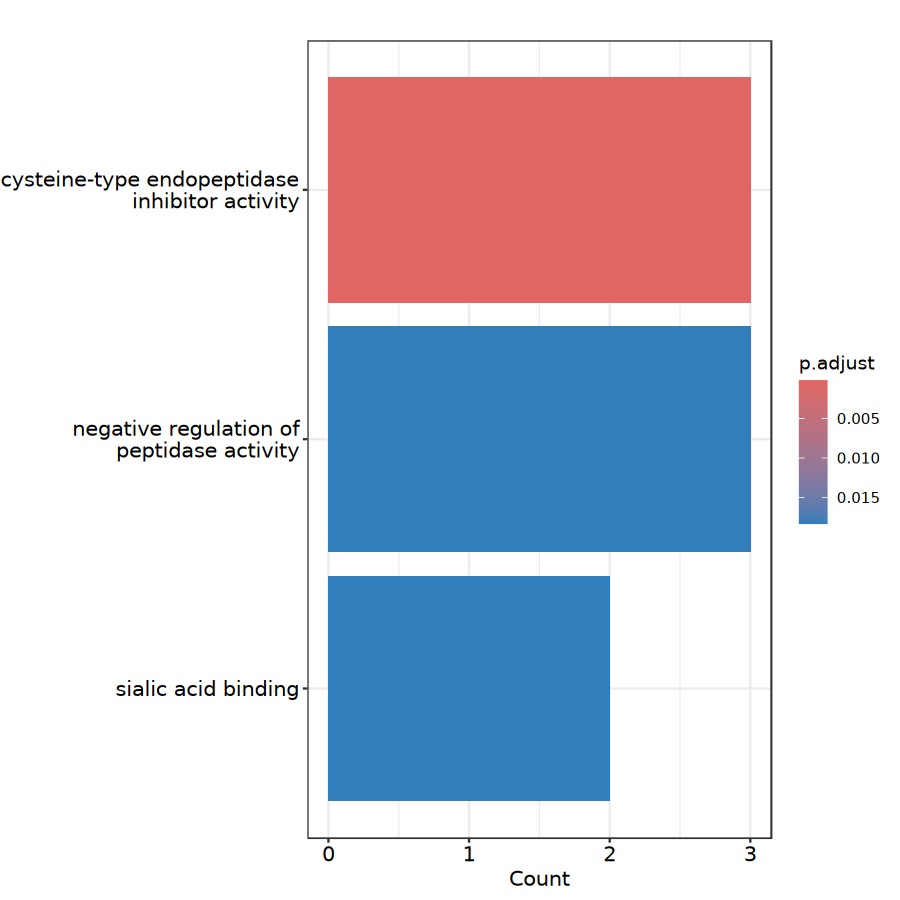

In [55]:
options(repr.plot.width=7.5, repr.plot.height=7.5)

# warm vs. control
w.c.bar <- barplot(res_sig.w.c)
w.c.bar

In [56]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/plots/ORA.hc_bar.pdf', w.c.bar, width=7.5, height=7.5)

Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


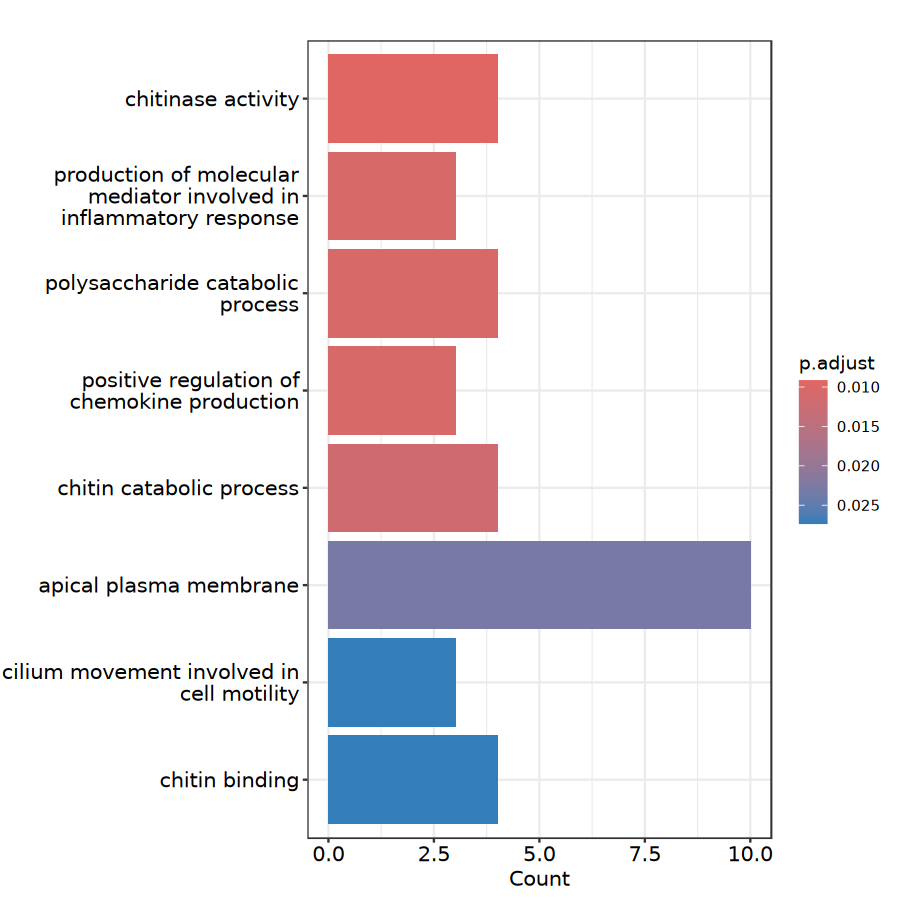

In [58]:
# both vs. control
b.c.bar <- barplot(res_sig.b.c)
b.c.bar

In [59]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/plots/ORA.bc_bar.pdf', b.c.bar, width=7.5, height=7.5)

Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


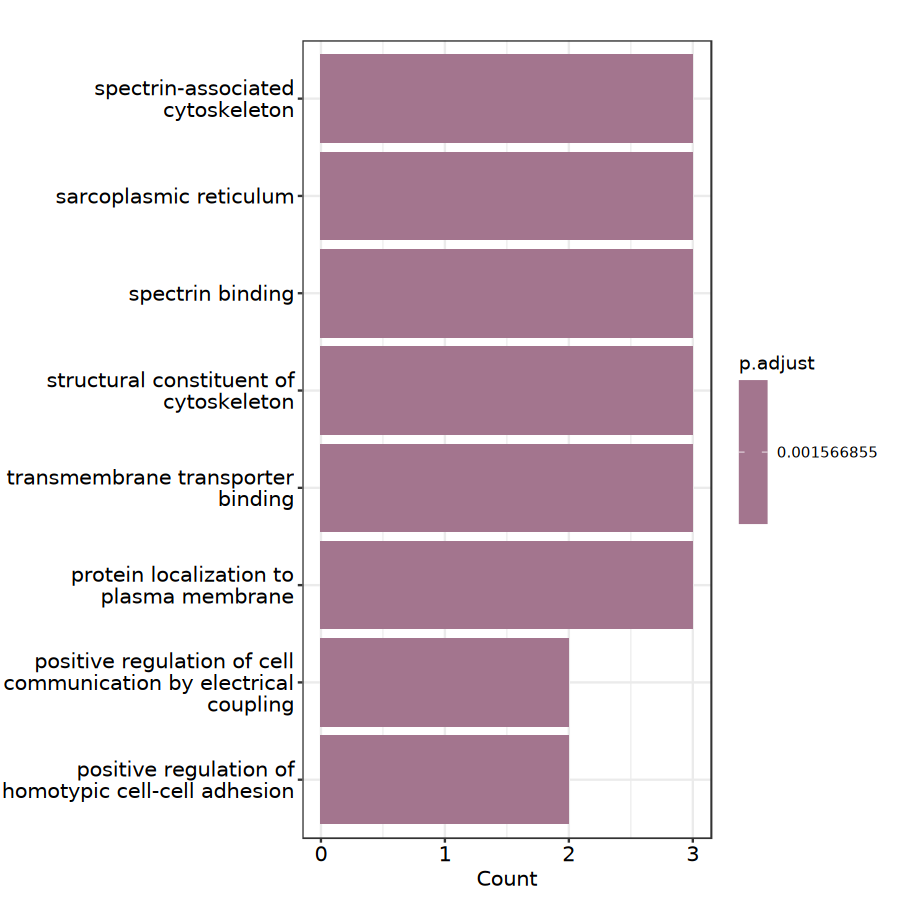

In [61]:
# hypoxic vs. control
h.c.bar <- barplot(res_sig.h.c)
h.c.bar

In [62]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/plots/ORA.hc_bar.pdf', h.c.bar, width=7.5, height=7.5)

Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


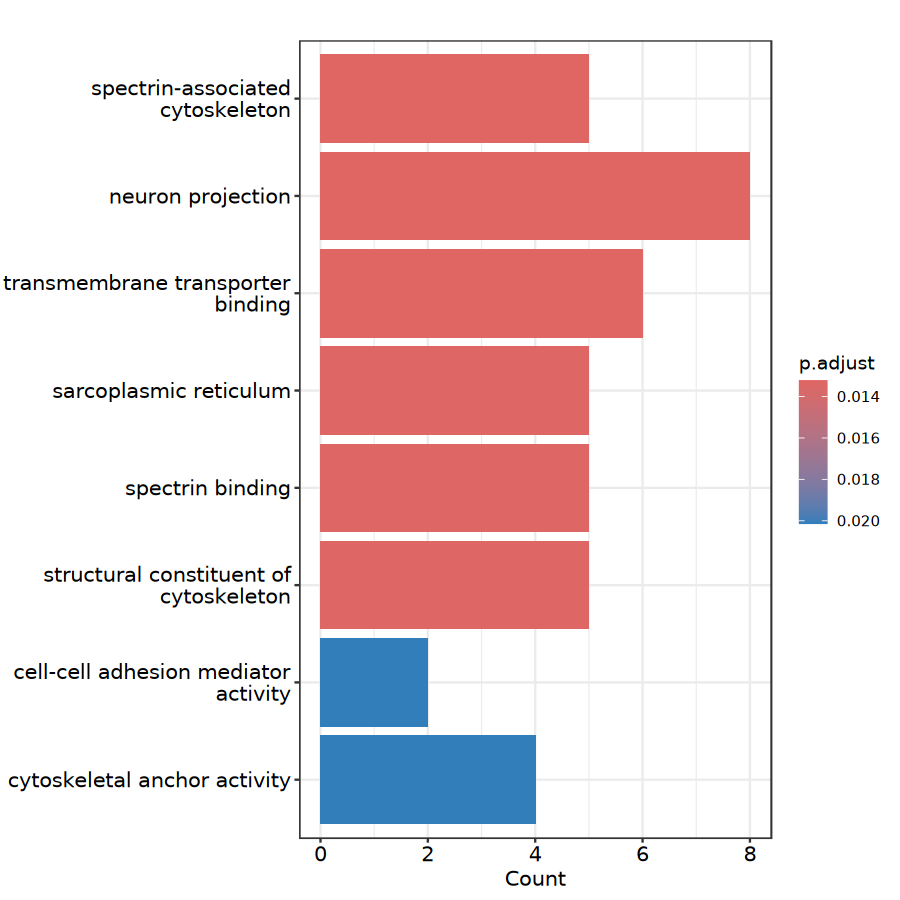

In [63]:
# hypoxic vs. both
h.b.bar <- barplot(res_sig.h.b)
h.b.bar

In [64]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/plots/ORA.hb_bar.pdf', h.b.bar, width=7.5, height=7.5)

Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


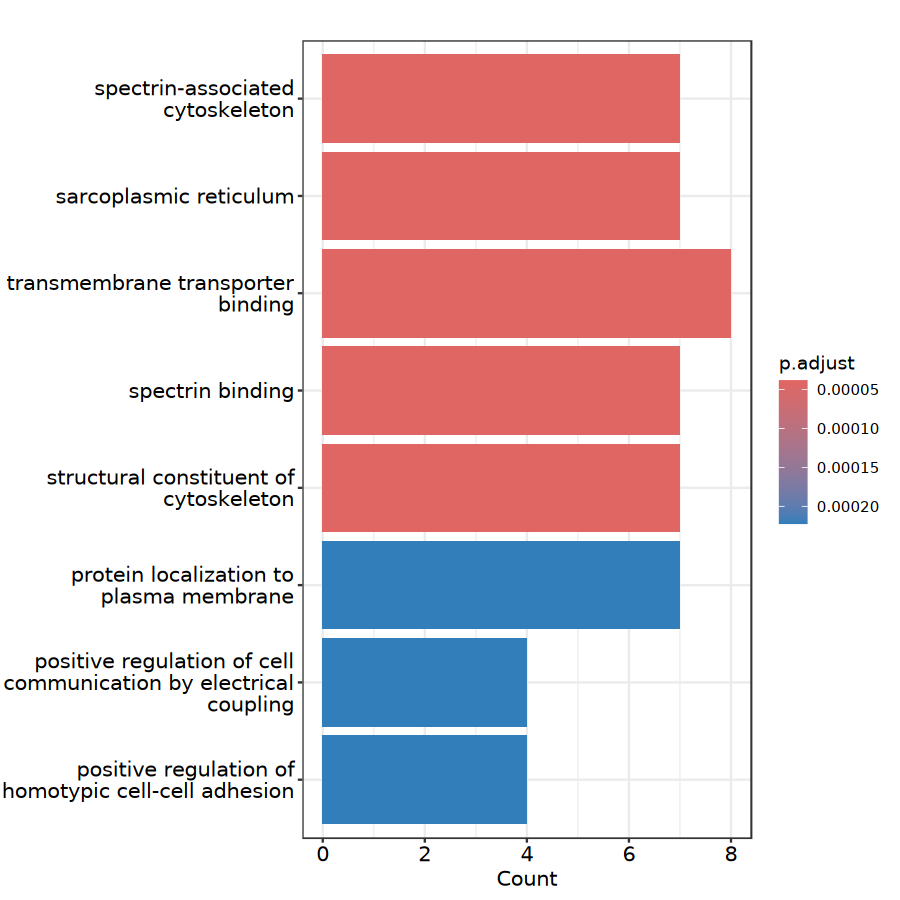

In [66]:
# warm vs. both
w.b.bar <- barplot(res_sig.w.b)
w.b.bar

In [67]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/plots/ORA.wb_bar.pdf', w.b.bar, width=7.5, height=7.5)

Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


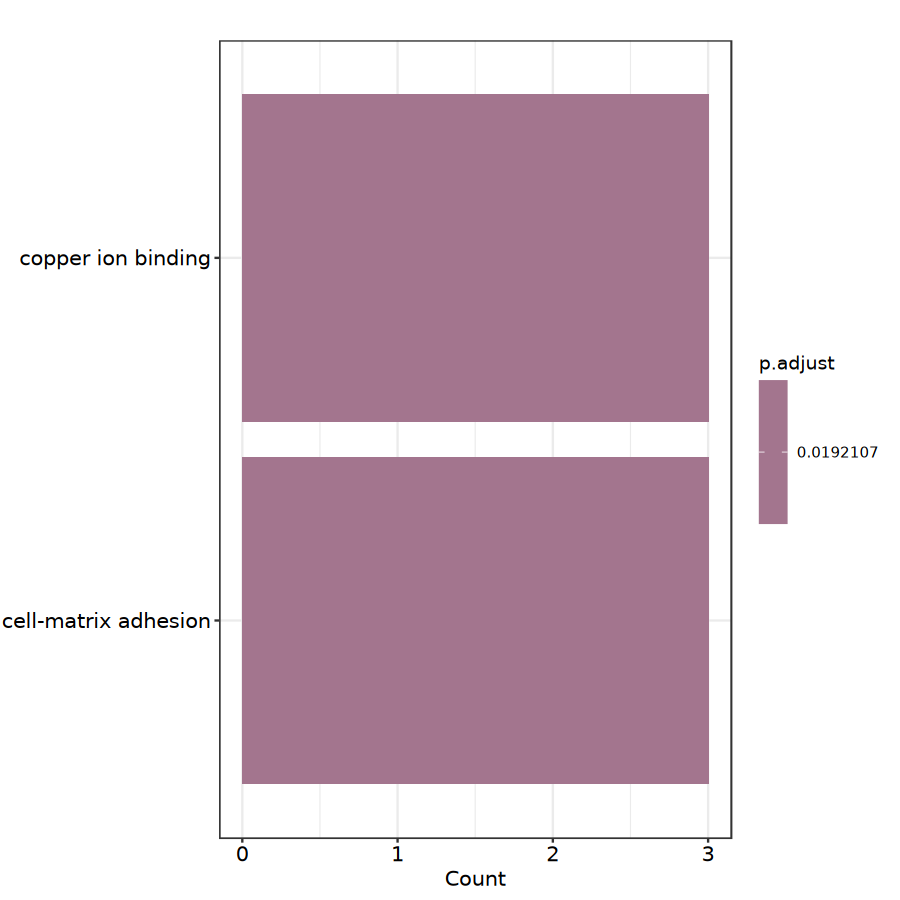

In [68]:
# warm vs. hypoxic
w.h.bar <- barplot(res_sig.w.h) 
w.h.bar

In [69]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/plots/ORA.wh_bar.pdf', w.h.bar, width=7.5, height=7.5)

### upset plots

In [31]:
head(res_sig.h.c, 2)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,3/9,135/16641,4.232257e-05,0.001566855,0.0003423119,LOC111108483/LOC111105823/LOC111113858,3
GO:0016529,GO:0016529,sarcoplasmic reticulum,3/9,154/16641,6.267524e-05,0.001566855,0.0003423119,LOC111108483/LOC111105823/LOC111113858,3


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the UpSetR package.
  Please report the issue to the authors.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the UpSetR package.
  Please report the issue to the authors.”


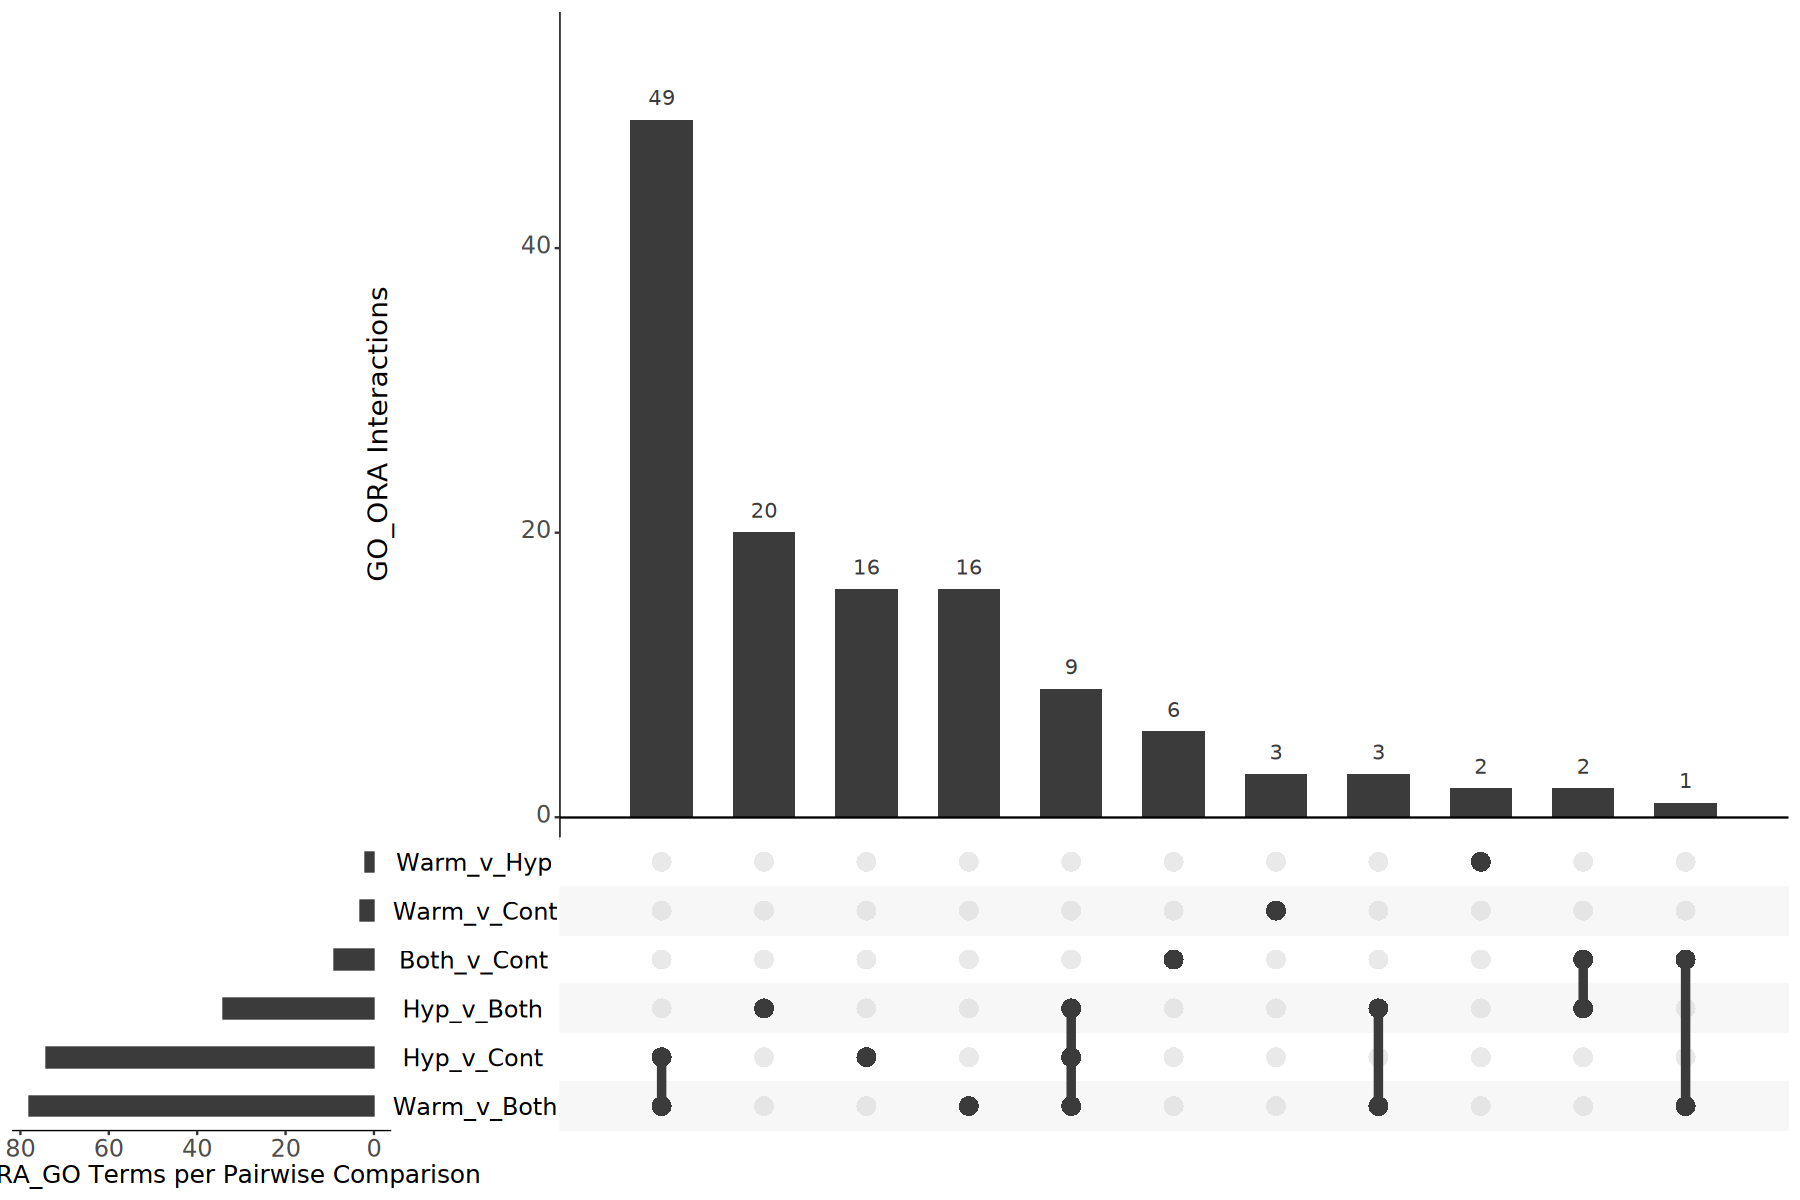

In [32]:
options(repr.plot.width=15, repr.plot.height=10)

all_list = list(Hyp_v_Both = res_sig.h.b$ID,
              Warm_v_Both = res_sig.w.b$ID,
              Warm_v_Hyp = res_sig.w.h$ID,
               Hyp_v_Cont = res_sig.h.c$ID,
               Warm_v_Cont = res_sig.w.c$ID,
               Both_v_Cont = res_sig.b.c$ID)

upset(fromList(all_list), nsets = 6,, order.by='freq', point.size = 5, line.size = 2, 
    mainbar.y.label = "GO_ORA Interactions", sets.x.label = "Sig. ORA_GO Terms per Pairwise Comparison", 
    text.scale = c(2, 2, 1.75, 2, 2, 2))

as a reminder - ORA is asking out of the list of differentially expressed genes, are there any gene sets that are over-represented? 

Here, we're looking at the overlap of significantly over-represented GO terms within our list of DEGs

Surprisingly, Hyp vs. Cont and Warm vs. Both have the most overlap in GO terms - so those gene sets (and probably related functions) are seen more in DEGs than you would expect by change - looking at the upset plot of just DEGs in [venn_p1.v.p1.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/venn_p1.v.p1.ipynb), these comparisons shared some DEGs, but not a ton (and none shared uniquely between these comparisons)

this might suggest that while the DEGs are different, there's some functional redundancy/similar pathways affected - but also, these two groups had the most enriched/over-represented GO terms

## ORA in Up- or Down-Regulated DEGs
basically repeating the above section, but splitting the DEG sets into up- or down- regulated to look at patterns there

(only doing this for comparisons against control for simplicity)

### Phase 1 Warm vs. Control

In [33]:
w.c_up <- w.c_deg %>%
filter(log2FoldChange > 0)
w.c_up <- w.c_up$X
head(w.c_up)

w.c_down <- w.c_deg %>%
filter(log2FoldChange < 0)
w.c_down <- w.c_down$X
head(w.c_down)

[1] "LOC111121183" "LOC111106303" "LOC111122541" "LOC111130453" "LOC111120021"
[6] "LOC111135464"

[1] "LOC111129171" "LOC111135260" "LOC111104602" "LOC111101935" "LOC111119500"
[6] "LOC111120933"

In [34]:
# warm vs. control UP
w.c_up.res <- enricher(
    gene = w.c_up,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = w.h$X)

w.c_up.ora <- as.data.frame(w.c_up.res)

head(w.c_up.ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0005975,GO:0005975,carbohydrate metabolic process,3/15,141/16641,0.0002514545,0.01904918,0.01023332,LOC111135464/LOC111100804/LOC111125414,3
GO:0004553,GO:0004553,"hydrolase activity, hydrolyzing O-glycosyl compounds",2/15,27/16641,0.0002627474,0.01904918,0.01023332,LOC111135464/LOC111100804,2
GO:0004089,GO:0004089,carbonate dehydratase activity,2/15,35/16641,0.0004435465,0.02143808,0.01151664,LOC111137424/LOC111117514,2


In [35]:
# warm vs. control DOWN
w.c_down.res <- enricher(
    gene = w.c_down,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = w.h$X)

w.c_down.ora <- as.data.frame(w.c_down.res)

head(w.c_down.ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004869,GO:0004869,cysteine-type endopeptidase inhibitor activity,3/14,11/16641,7.790285e-08,5.297394e-06,3.116114e-06,LOC111114881/LOC111113359/LOC111117444,3
GO:0010466,GO:0010466,negative regulation of peptidase activity,3/14,67/16641,2.199791e-05,7.479291e-04,4.399583e-04,LOC111114881/LOC111113359/LOC111117444,3
GO:0033691,GO:0033691,sialic acid binding,2/14,14/16641,5.946671e-05,1.347912e-03,7.928895e-04,LOC111125904/LOC111123027,2
GO:0043654,GO:0043654,recognition of apoptotic cell,2/14,85/16641,2.254668e-03,3.832936e-02,2.254668e-02,LOC111125904/LOC111117000,2


In [36]:
w.c_down.ora$direction <- 'Down-Regulated DEGs'
w.c_up.ora$direction <- 'Up-Regulated DEGs'

w.c.ora <- rbind(w.c_up.ora, w.c_down.ora)
head(w.c.ora, 2)
tail(w.c.ora,2)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,direction
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
GO:0005975,GO:0005975,carbohydrate metabolic process,3/15,141/16641,0.0002514545,0.01904918,0.01023332,LOC111135464/LOC111100804/LOC111125414,3,Up-Regulated DEGs
GO:0004553,GO:0004553,"hydrolase activity, hydrolyzing O-glycosyl compounds",2/15,27/16641,0.0002627474,0.01904918,0.01023332,LOC111135464/LOC111100804,2,Up-Regulated DEGs


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,direction
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
GO:0033691,GO:0033691,sialic acid binding,2/14,14/16641,5.946671e-05,0.001347912,0.0007928895,LOC111125904/LOC111123027,2,Down-Regulated DEGs
GO:0043654,GO:0043654,recognition of apoptotic cell,2/14,85/16641,2.254668e-03,0.038329358,0.0225466809,LOC111125904/LOC111117000,2,Down-Regulated DEGs


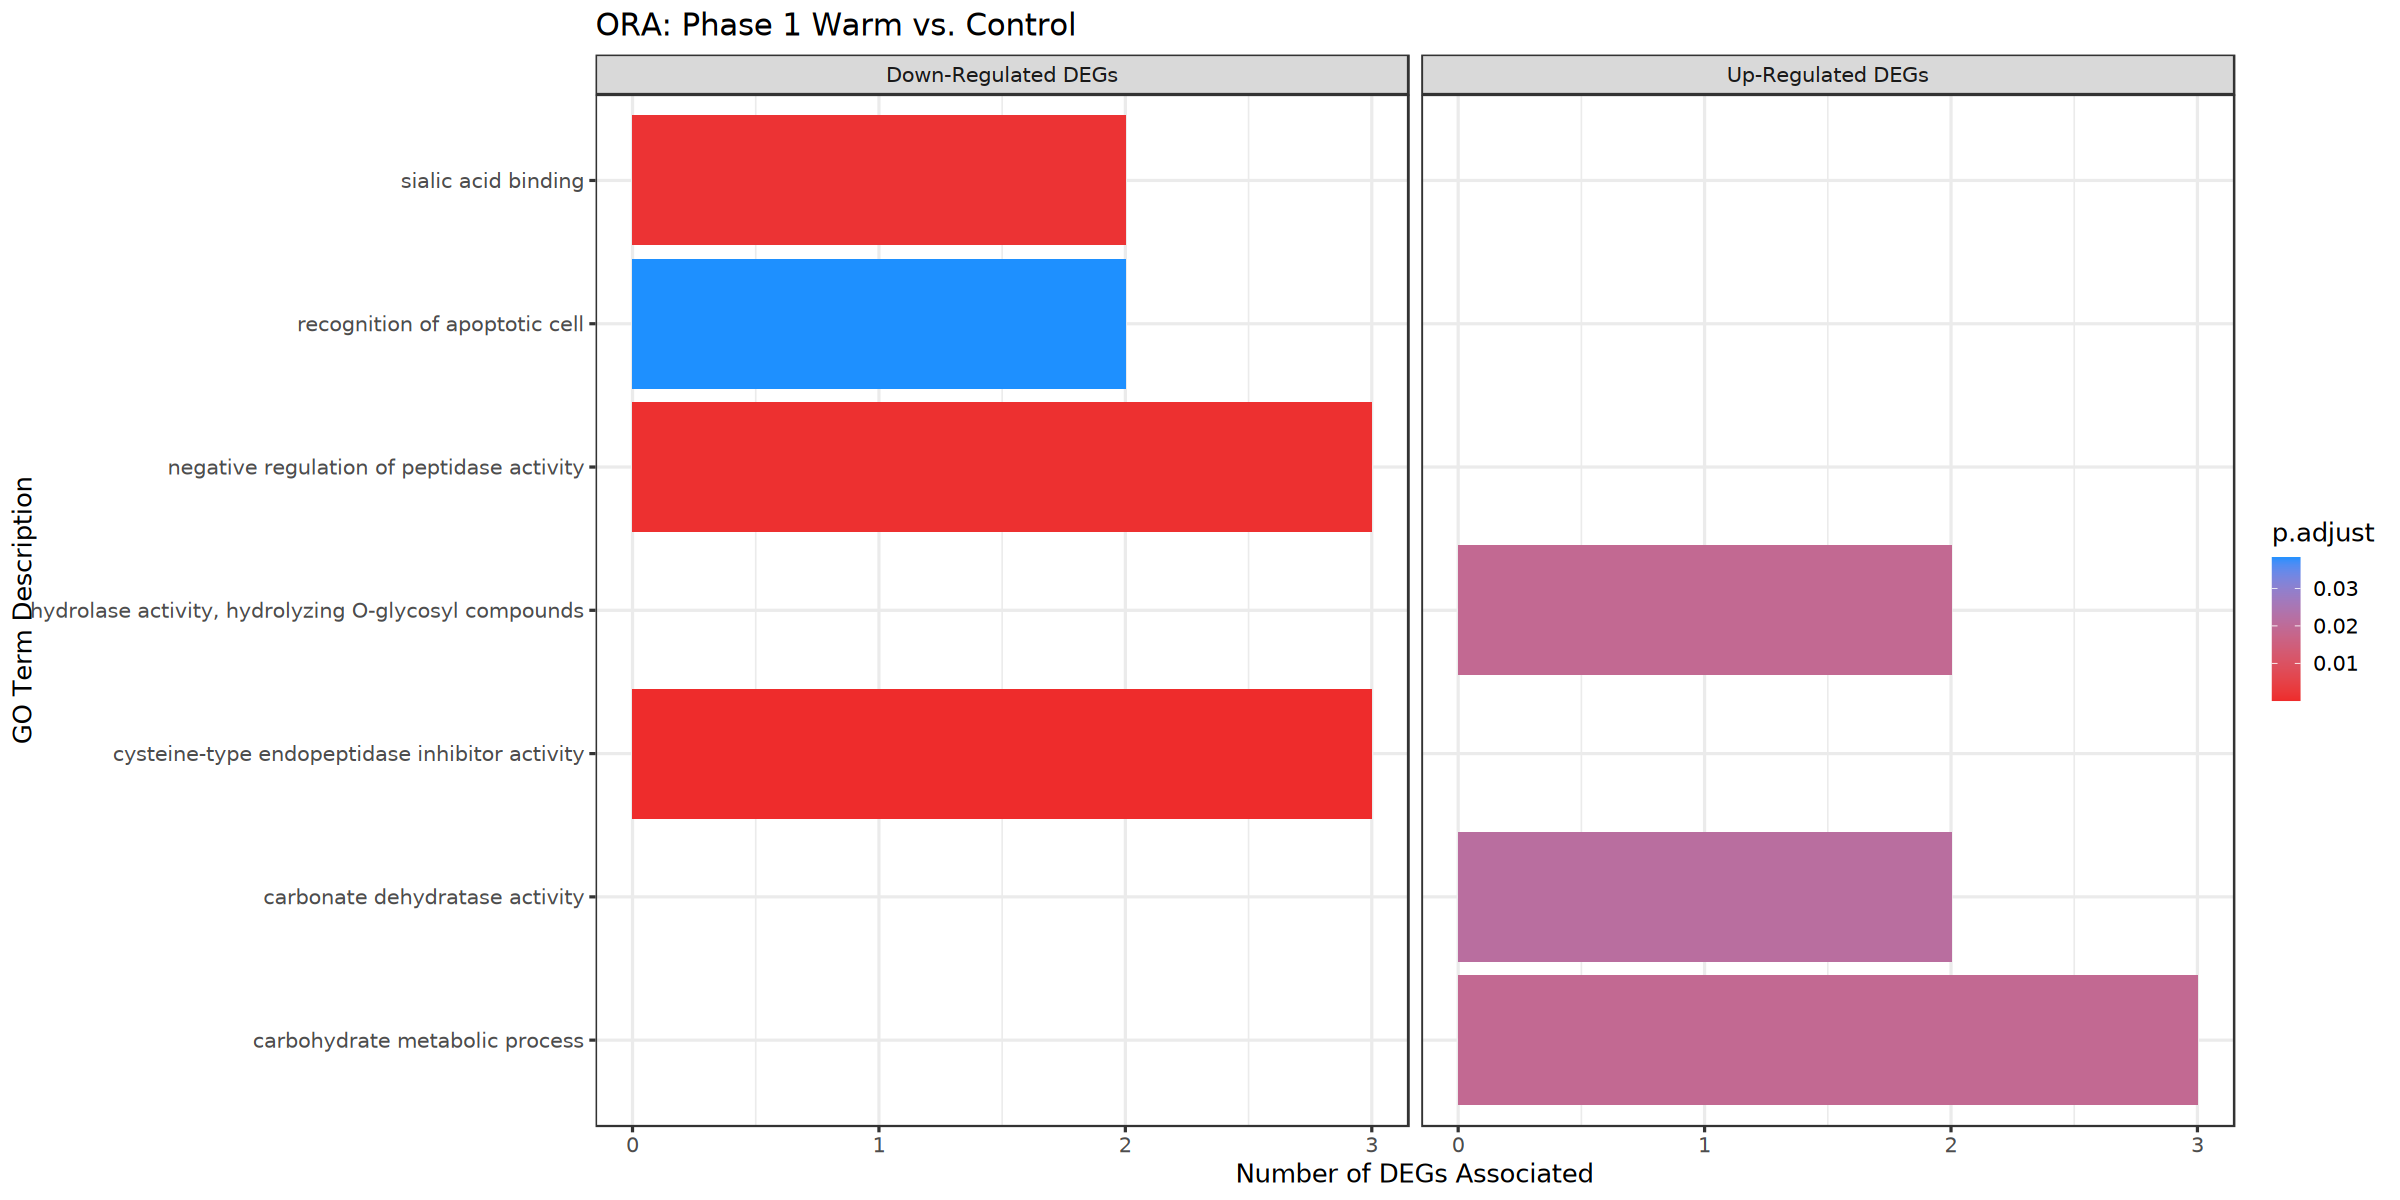

In [37]:
options(repr.plot.width=20, repr.plot.height=10)

w.c.bar <- ggplot(w.c.ora, aes(x=Description, y=Count)) +
geom_bar(stat = "identity", aes(fill=p.adjust)) + 
scale_fill_gradient(low = 'firebrick2', high = 'dodgerblue') +
coord_flip() +
theme_bw(base_size=15) +
facet_wrap(~direction) +
labs(title = 'ORA: Phase 1 Warm vs. Control',
    x = 'GO Term Description',
    y = 'Number of DEGs Associated')

w.c.bar

In [70]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/plots/ORA.wc.directional_bar.pdf', w.c.bar, width = 20, height = 10)

### Phase 1 Hypoxic vs. Control

In [39]:
h.c_up <- h.c_deg %>%
filter(log2FoldChange > 0)
h.c_up <- h.c_up$X
head(h.c_up)

h.c_down <- h.c_deg %>%
filter(log2FoldChange < 0)
h.c_down <- h.c_down$X
head(h.c_down)

[1] "LOC111121183" "LOC111120021" "LOC111119724" "LOC111119726" "LOC111125414"
[6] "LOC111123780"

[1] "LOC111138278" "LOC111134915" "LOC111132199" "LOC111100048" "LOC111105273"
[6] "LOC111102795"

In [40]:
# warm vs. control UP
h.c_up.res <- enricher(
    gene = h.c_up,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = w.h$X)

h.c_up.ora <- as.data.frame(h.c_up.res)

head(h.c_up.ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0009751,GO:0009751,response to salicylic acid,1/6,10/16641,0.003600680,0.04681457,0.01137196,LOC111105743,1
GO:0015802,GO:0015802,basic amino acid transport,1/6,10/16641,0.003600680,0.04681457,0.01137196,LOC111125414,1
GO:0015174,GO:0015174,basic amino acid transmembrane transporter activity,1/6,13/16641,0.004678775,0.04681457,0.01137196,LOC111125414,1
GO:0015810,GO:0015810,aspartate transmembrane transport,1/6,14/16641,0.005037924,0.04681457,0.01137196,LOC111125414,1
GO:0005768,GO:0005768,endosome,2/6,319/16641,0.005221839,0.04681457,0.01137196,LOC111112437/LOC111112788,2
GO:0030422,GO:0030422,siRNA processing,1/6,17/16641,0.006114723,0.04681457,0.01137196,LOC111105743,1


In [41]:
# warm vs. control DOWN
h.c_down.res <- enricher(
    gene = h.c_down,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = w.h$X)

h.c_down.ora <- as.data.frame(h.c_down.res)

head(h.c_down.ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,2/3,135/16641,0.0001949425,0.005668733,0.0005496002,LOC111105823/LOC111113858,2
GO:0016529,GO:0016529,sarcoplasmic reticulum,2/3,154/16641,0.0002537159,0.005668733,0.0005496002,LOC111105823/LOC111113858,2
GO:0030507,GO:0030507,spectrin binding,2/3,161/16641,0.0002773057,0.005668733,0.0005496002,LOC111105823/LOC111113858,2
GO:0005200,GO:0005200,structural constituent of cytoskeleton,2/3,167/16641,0.0002983544,0.005668733,0.0005496002,LOC111105823/LOC111113858,2
GO:0044325,GO:0044325,transmembrane transporter binding,2/3,231/16641,0.0005703286,0.007667434,0.0007433801,LOC111105823/LOC111113858,2
GO:0072659,GO:0072659,protein localization to plasma membrane,2/3,238/16641,0.0006053238,0.007667434,0.0007433801,LOC111105823/LOC111113858,2


In [42]:
h.c_down.ora$direction <- 'Down-Regulated DEGs'
h.c_up.ora$direction <- 'Up-Regulated DEGs'

h.c.ora <- rbind(h.c_up.ora, h.c_down.ora)
head(h.c.ora, 2)
tail(h.c.ora,2)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,direction
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
GO:0009751,GO:0009751,response to salicylic acid,1/6,10/16641,0.00360068,0.04681457,0.01137196,LOC111105743,1,Up-Regulated DEGs
GO:0015802,GO:0015802,basic amino acid transport,1/6,10/16641,0.00360068,0.04681457,0.01137196,LOC111125414,1,Up-Regulated DEGs


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,direction
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
GO:0019903,GO:0019903,protein phosphatase binding,1/3,228/16641,0.04054511,0.04531513,0.004393433,LOC111113858,1,Down-Regulated DEGs
GO:0045296,GO:0045296,cadherin binding,1/3,235/16641,0.04177226,0.04601003,0.004460806,LOC111105823,1,Down-Regulated DEGs


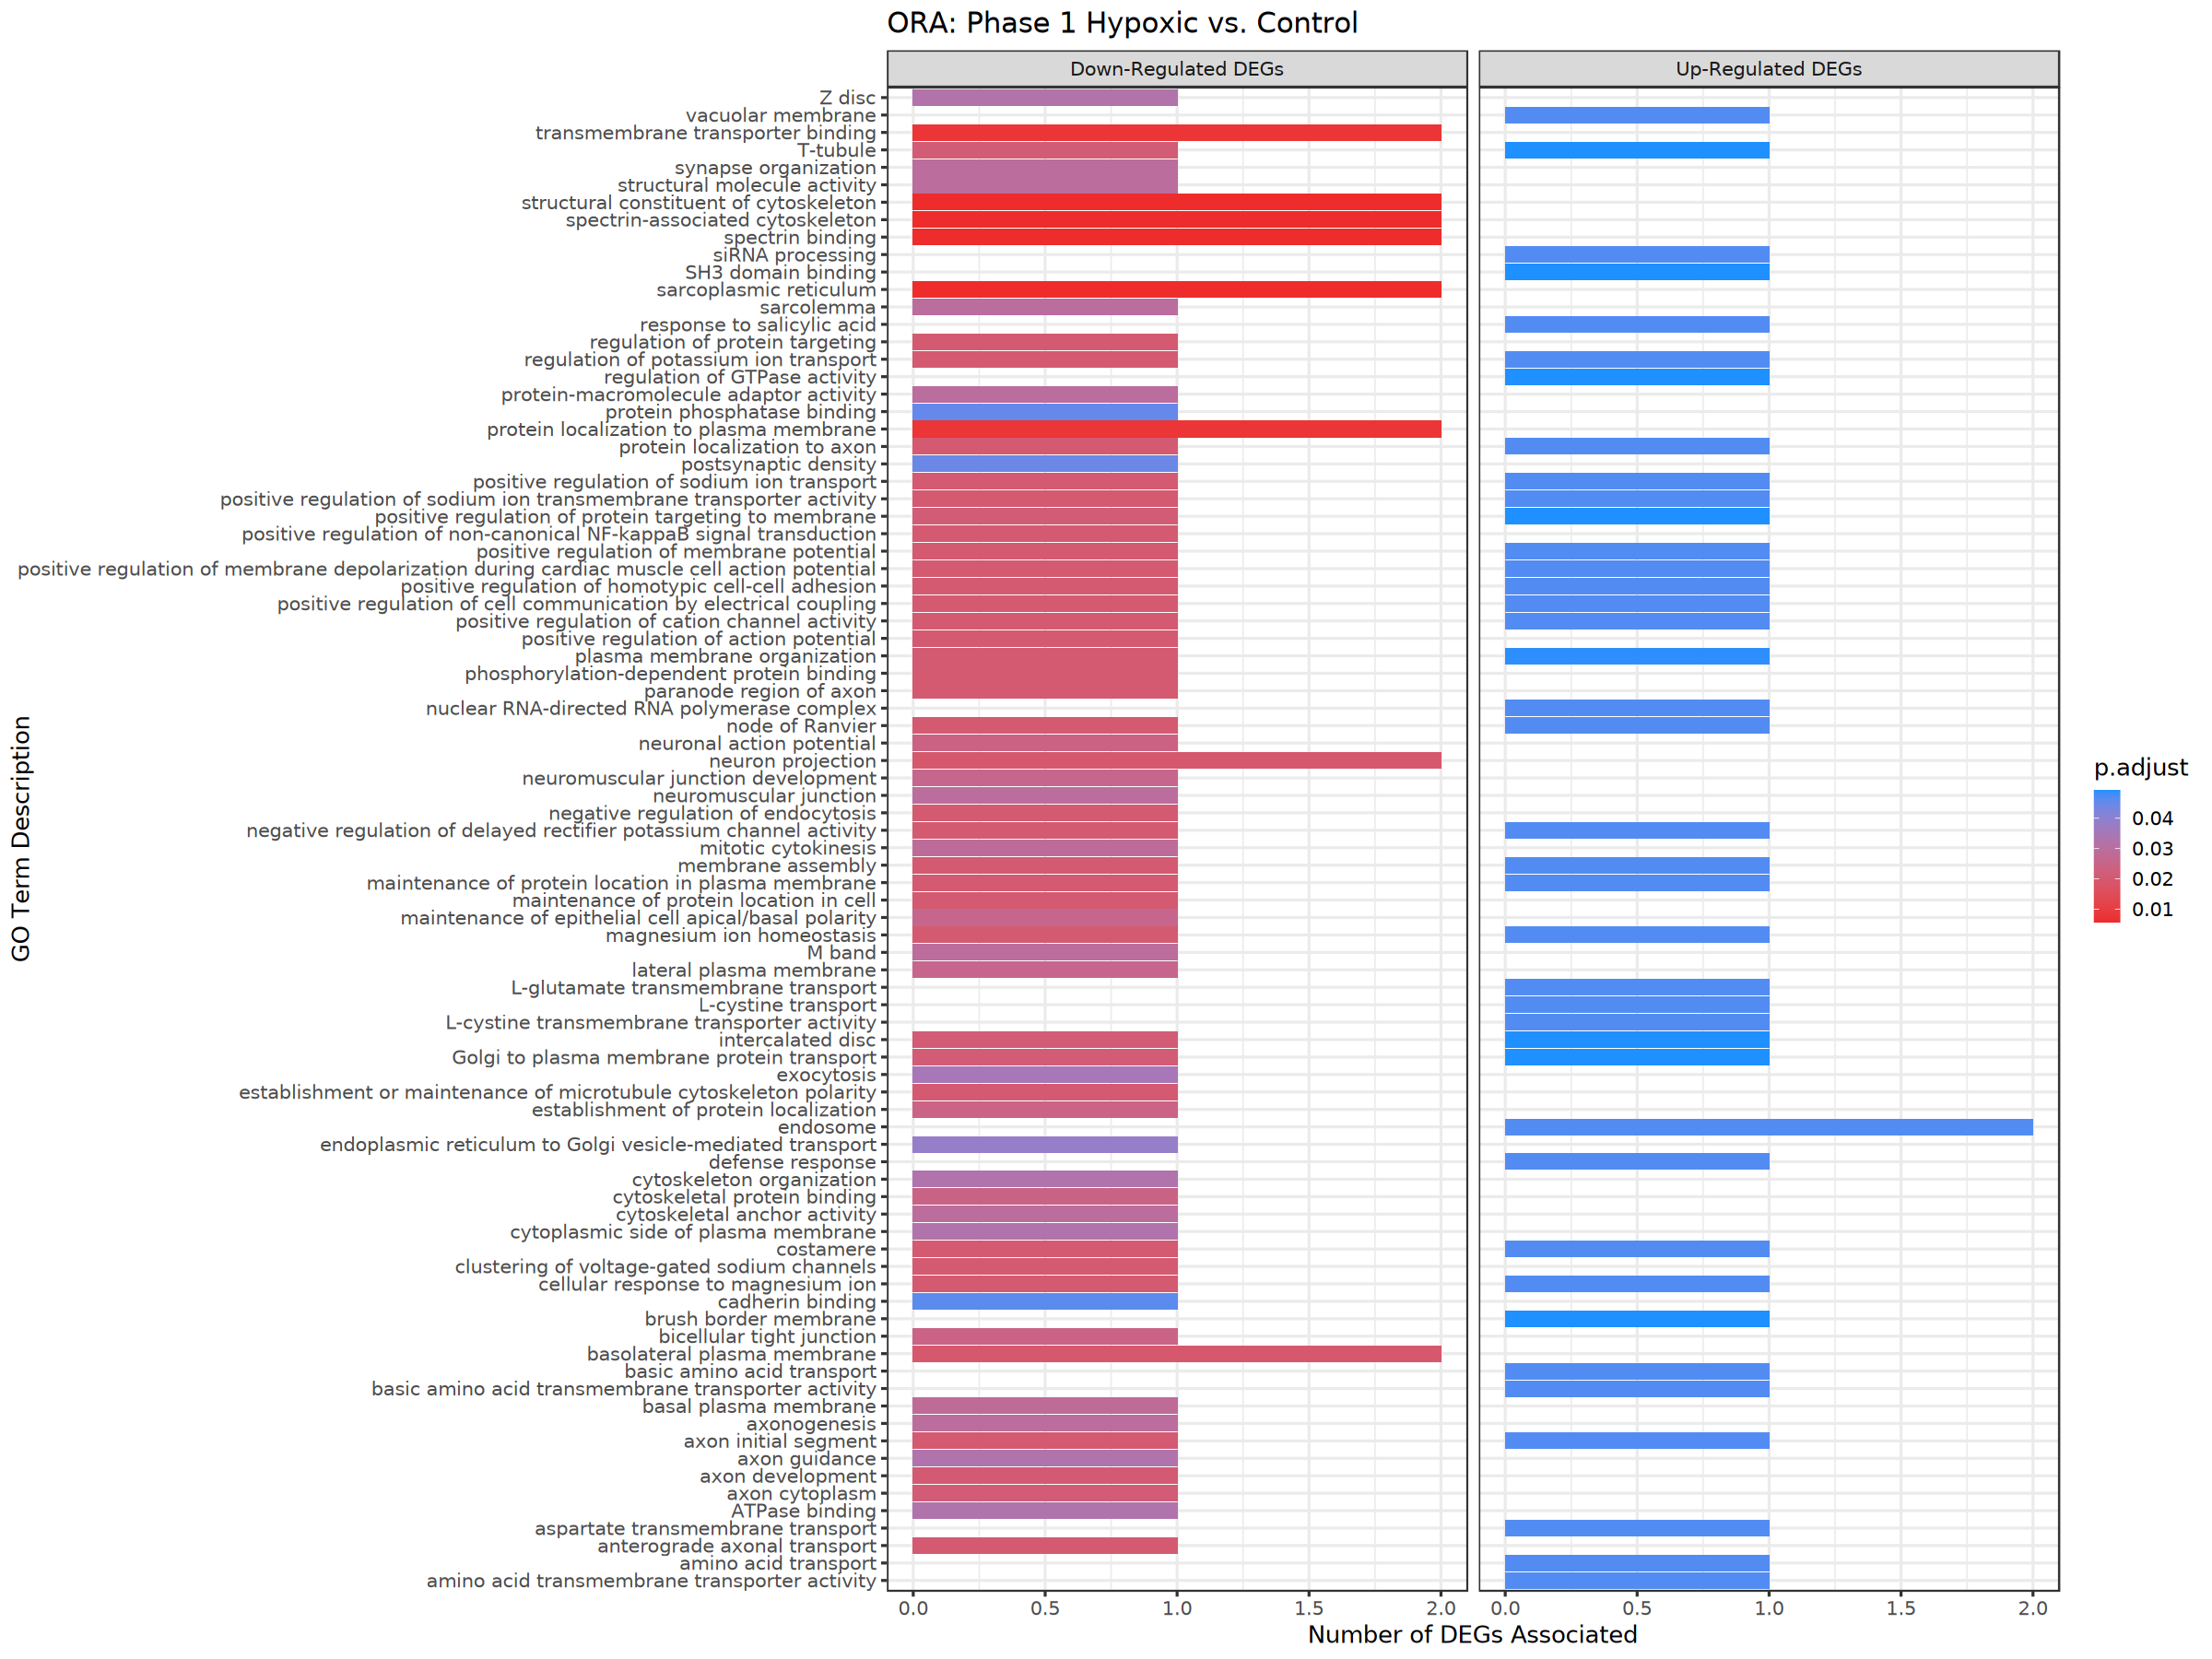

In [43]:
options(repr.plot.width=20, repr.plot.height=15)

h.c.bar <- ggplot(h.c.ora, aes(x=Description, y=Count)) +
geom_bar(stat = "identity", aes(fill=p.adjust)) + 
scale_fill_gradient(low = 'firebrick2', high = 'dodgerblue') +
coord_flip() +
theme_bw(base_size=15) +
facet_wrap(~direction) +
labs(title = 'ORA: Phase 1 Hypoxic vs. Control',
    x = 'GO Term Description',
    y = 'Number of DEGs Associated')

h.c.bar

In [71]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/plots/ORA.hc.directional_bar.pdf', h.c.bar, width = 20, height = 10)

### Phase 1 Both vs. Control

In [45]:
b.c_up <- b.c_deg %>%
filter(log2FoldChange > 0)
b.c_up <- b.c_up$X
head(b.c_up)

b.c_down <- b.c_deg %>%
filter(log2FoldChange < 0)
b.c_down <- b.c_down$X
head(b.c_down)

[1] "LOC111104630" "LOC111121183" "LOC111130465" "LOC111120021" "LOC111120117"
[6] "LOC111134586"

[1] "LOC111119645" "LOC111111234" "LOC111129171" "LOC111111721" "LOC111111747"
[6] "LOC111106320"

In [46]:
# both vs. control UP
b.c_up.res <- enricher(
    gene = b.c_up,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = w.h$X)

b.c_up.ora <- as.data.frame(b.c_up.res)

head(b.c_up.ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0030422,GO:0030422,siRNA processing,2/21,17/16641,0.000203937,0.01631496,0.01062619,LOC111108349/LOC111105743,2
GO:0031380,GO:0031380,nuclear RNA-directed RNA polymerase complex,2/21,17/16641,0.000203937,0.01631496,0.01062619,LOC111108349/LOC111105743,2


In [47]:
# both vs. control DOWN
b.c_down.res <- enricher(
    gene = b.c_down,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = w.h$X)

b.c_down.ora <- as.data.frame(b.c_down.res)

head(b.c_down.ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004568,GO:0004568,chitinase activity,4/85,24/16641,6.230726e-06,0.003090440,0.002597229,LOC111119837/LOC111124157/LOC111125216/LOC111125215,4
GO:0000272,GO:0000272,polysaccharide catabolic process,4/85,34/16641,2.615540e-05,0.004066022,0.003417115,LOC111119837/LOC111124157/LOC111125216/LOC111125215,4
GO:0002532,GO:0002532,production of molecular mediator involved in inflammatory response,3/85,12/16641,2.737008e-05,0.004066022,0.003417115,LOC111124157/LOC111125216/LOC111125215,3
GO:0032722,GO:0032722,positive regulation of chemokine production,3/85,13/16641,3.544982e-05,0.004066022,0.003417115,LOC111124157/LOC111125216/LOC111125215,3
GO:0006032,GO:0006032,chitin catabolic process,4/85,38/16641,4.098813e-05,0.004066022,0.003417115,LOC111119837/LOC111124157/LOC111125216/LOC111125215,4
GO:0008061,GO:0008061,chitin binding,4/85,53/16641,1.533983e-04,0.012005428,0.010089452,LOC111119837/LOC111124157/LOC111125216/LOC111125215,4


In [48]:
b.c_down.ora$direction <- 'Down-Regulated DEGs'
b.c_up.ora$direction <- 'Up-Regulated DEGs'

b.c.ora <- rbind(b.c_up.ora, b.c_down.ora)
head(b.c.ora, 2)
tail(b.c.ora,2)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,direction
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
GO:0030422,GO:0030422,siRNA processing,2/21,17/16641,0.000203937,0.01631496,0.01062619,LOC111108349/LOC111105743,2,Up-Regulated DEGs
GO:0031380,GO:0031380,nuclear RNA-directed RNA polymerase complex,2/21,17/16641,0.000203937,0.01631496,0.01062619,LOC111108349/LOC111105743,2,Up-Regulated DEGs


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,direction
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
GO:0030414,GO:0030414,peptidase inhibitor activity,2/85,10/16641,0.001129847,0.04670036,0.03924733,LOC111099569/LOC111099841,2,Down-Regulated DEGs
GO:0098632,GO:0098632,cell-cell adhesion mediator activity,2/85,10/16641,0.001129847,0.04670036,0.03924733,LOC111125416/LOC111125415,2,Down-Regulated DEGs


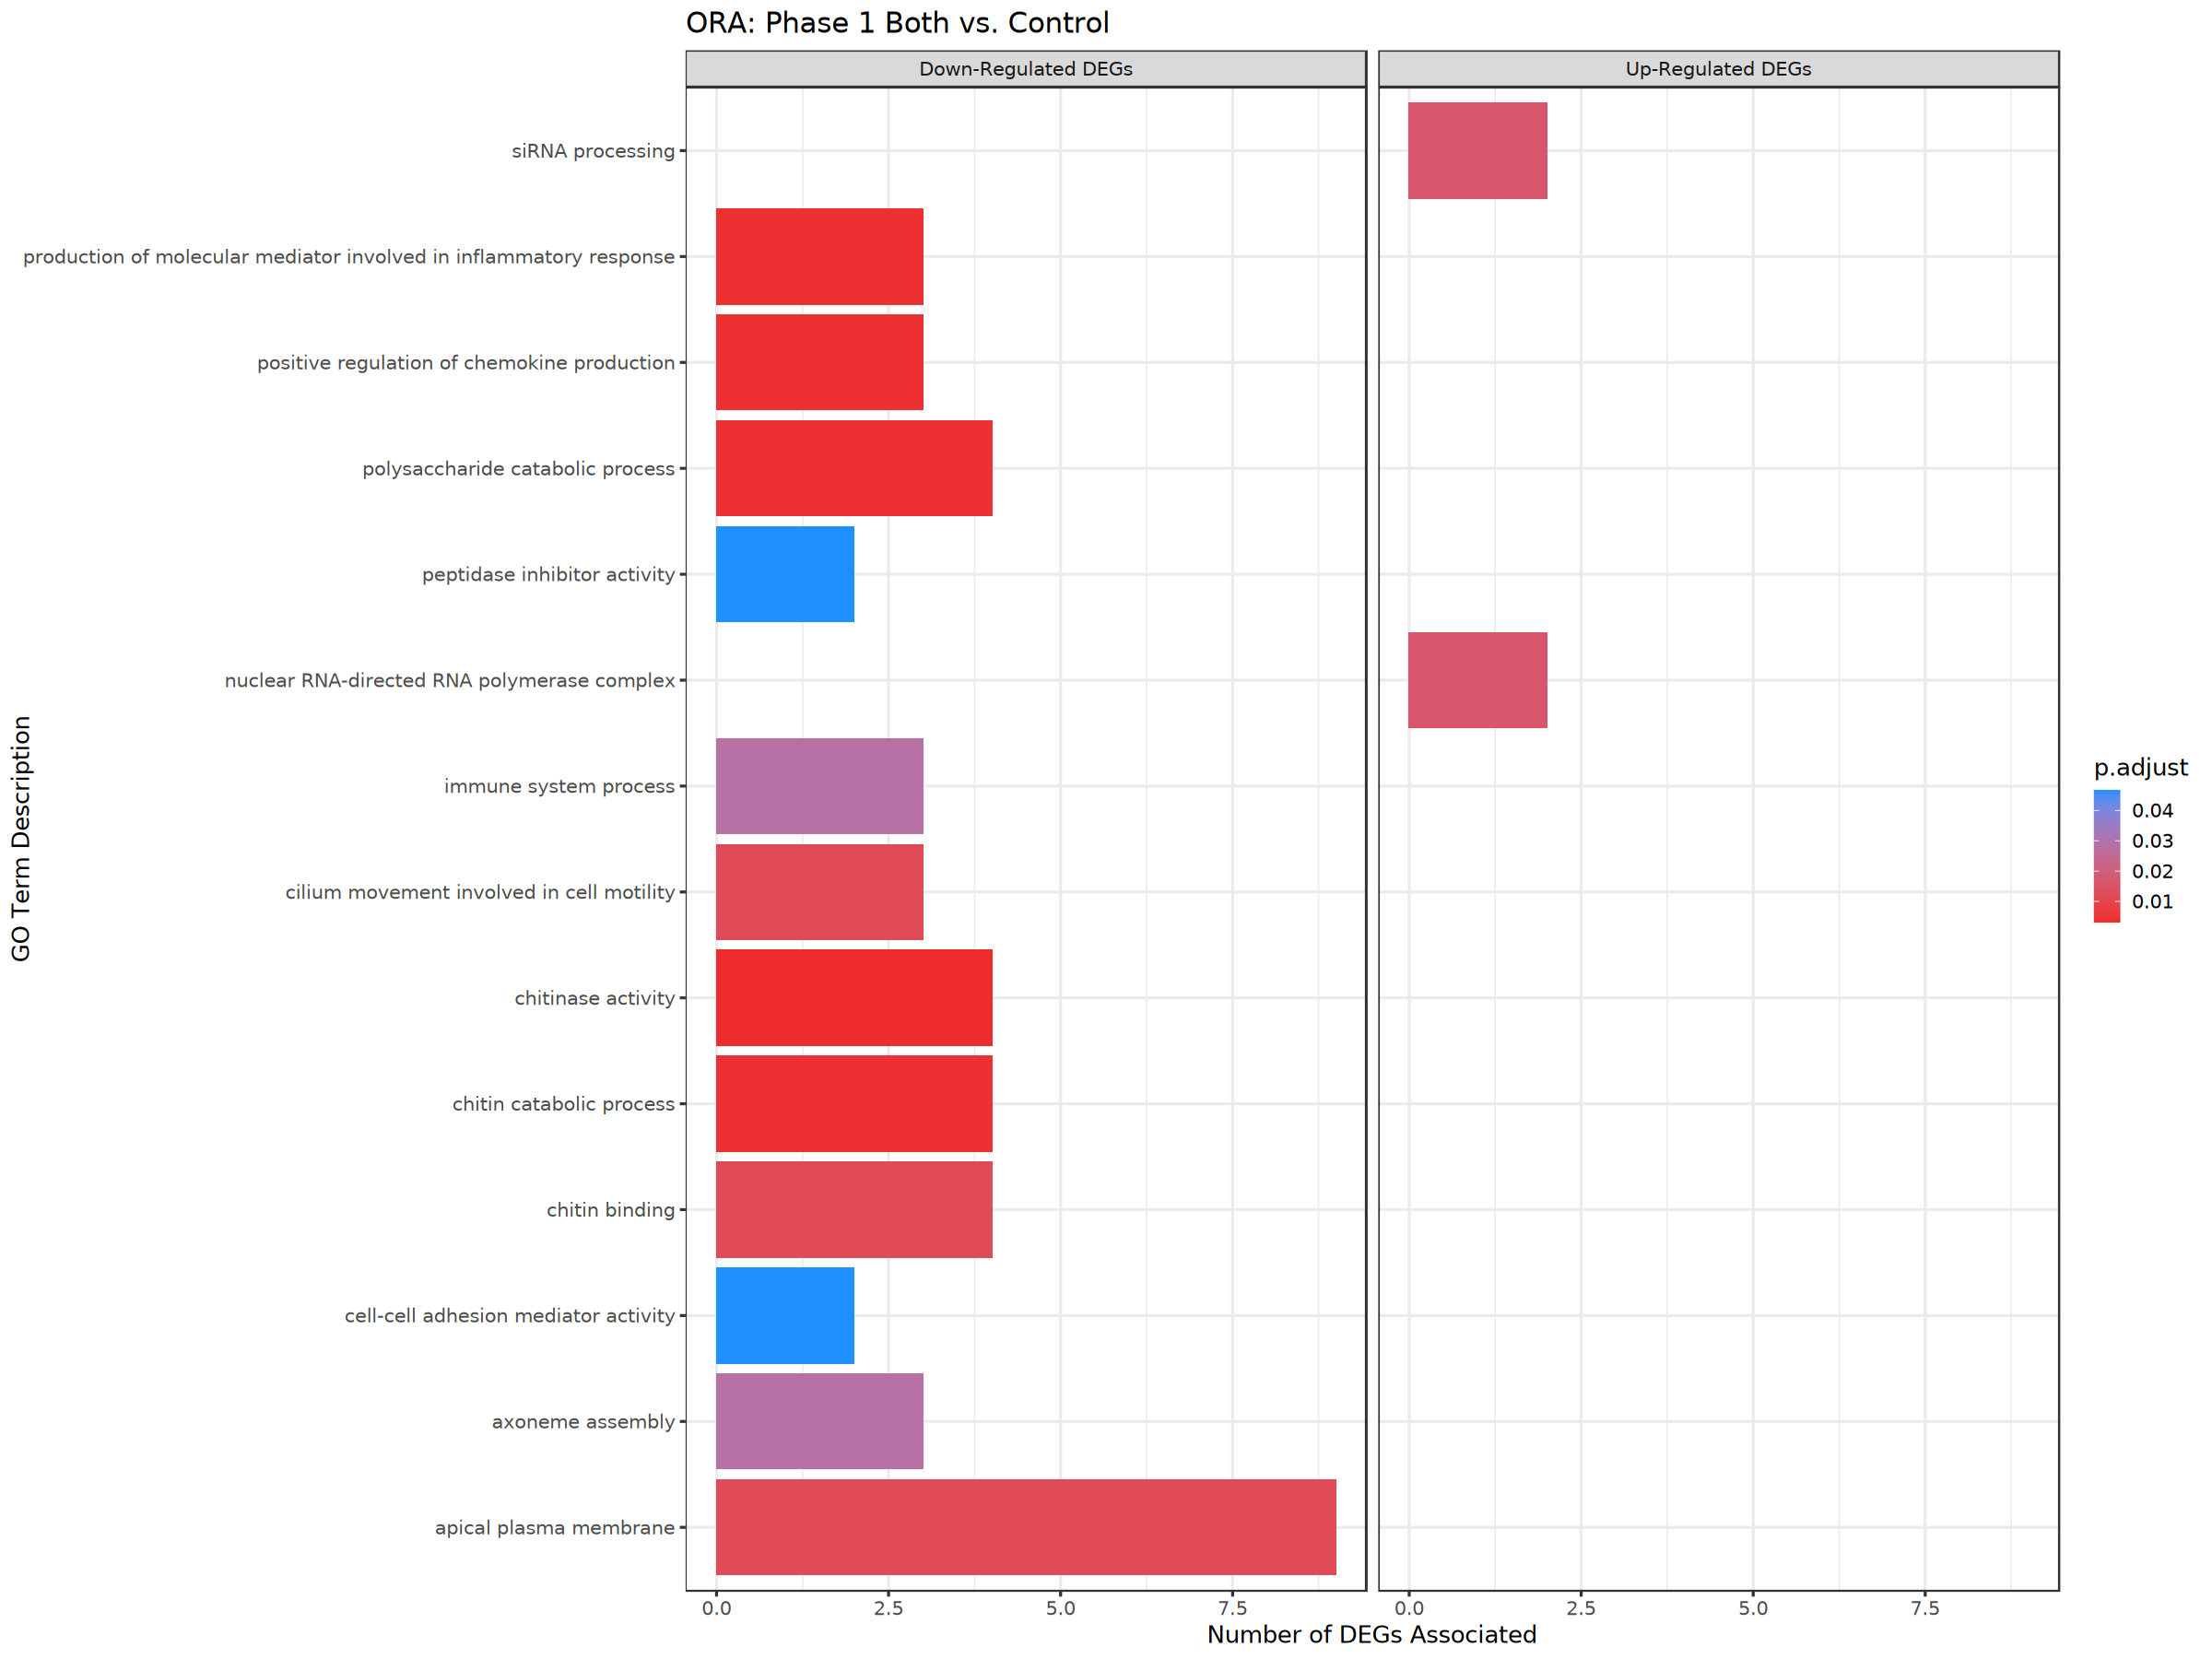

In [49]:
options(repr.plot.width=20, repr.plot.height=15)

b.c.bar <- ggplot(b.c.ora, aes(x=Description, y=Count)) +
geom_bar(stat = "identity", aes(fill=p.adjust)) + 
scale_fill_gradient(low = 'firebrick2', high = 'dodgerblue') +
coord_flip() +
theme_bw(base_size=15) +
facet_wrap(~direction) +
labs(title = 'ORA: Phase 1 Both vs. Control',
    x = 'GO Term Description',
    y = 'Number of DEGs Associated')

b.c.bar

In [72]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/plots/ORA.bc.directional_bar.pdf', b.c.bar, width = 20, height = 10)

there's 3 GO terms that have to do with chitin (12 DEGs that are over-represented for chitin-related processes) which is interesting - chitin is a polysaccharide that is typically used for structural support and is found in oyster shells